#### Name: Reda Mohsen Reda
#### ID: 18P5141
#### Course: Deep Learning
#### Topic: Hand Gesture Recognition Project

# Instal Dependencies

In [1]:
# !pip install tensorflow opencv-python albumentations matplotlib numpy seaborn ipympl PIL

# Import Libraries and Setup GPU

In [2]:
# Importing tensorflow and Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Concatenate
from keras.optimizers import Adam
from keras.layers import Input, Dropout, Dense, Flatten
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [3]:
# Importing used libraries
import os
import albumentations as A
import cv2 as cv
import time
from PIL import Image
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import random

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# About Data

[`hand-gesture-recognition-dataset`](https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset?resource=download) This dataset contains total 24000 images of 20 different gestures. For training purpose, there are 900 images in each directory and for testing purpose there are 300 images in each directory.

![Full dataset](Images/dataset-cover.png)

# Preprocess Data

Preprocess the dataset using [`albumentations`](https://albumentations.ai/docs/api_reference/augmentations/transforms/). Now for training purpose, there are 1800 images in each directory and for testing purpose there are 600 images in each directory after augmentations.

In [5]:
# Define the data augmentation options you want to apply using Albumentations
transform = A.Compose([
    A.RandomRotate90(), # randomly rotate the image by 90 degrees
    A.HorizontalFlip(p=0.6), # randomly flip the image horizontally
    A.RandomBrightnessContrast(), # randomly adjust the brightness and contrast
    A.OneOf([
        A.CoarseDropout (p=0.6), # randomly cutout the images
        A.Blur(), # randomly blur the image
        A.GaussNoise(), # randomly add Gaussian noise to the image
    ]), # randomly apply one of the above augmentations with a probability of 0.5
])

In [8]:
# Comment this part so dont do data augmentations each run
# set a counter to augmeent all the classes
counter = 0
for i in range(20):
    string_counter=str(counter)
    # Set the paths for your input directory and output directory
    # input_dir = 'dataset/train/'+string_counter+'/'
    # output_dir = 'dataset/train/'+string_counter+'/'
    input_dir = 'dataset/test/'+string_counter+'/'
    output_dir = 'dataset/test/'+string_counter+'/'
    print('Apply transform on ', input_dir)
    # Loop through the images in your dataset directory and apply the data augmentation using Albumentations
    for filename in os.listdir(input_dir):
        image = cv.imread(os.path.join(input_dir, filename)) # read the image using OpenCV
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # convert the image from BGR to RGB
        augmented = transform(image=image) # apply the data augmentation
        augmented_image = augmented['image'] # extract the augmented image from the result
        augmented_image = cv.cvtColor(augmented_image, cv.COLOR_RGB2BGR) # convert the image from RGB to BGR
        cv.imwrite(os.path.join(output_dir, 'augmented_'+string_counter+'_'+filename), augmented_image) # save the augmented image to the output directory
    counter +=1

Apply transform on  dataset/test/0/
Apply transform on  dataset/test/1/
Apply transform on  dataset/test/2/
Apply transform on  dataset/test/3/
Apply transform on  dataset/test/4/
Apply transform on  dataset/test/5/
Apply transform on  dataset/test/6/
Apply transform on  dataset/test/7/
Apply transform on  dataset/test/8/
Apply transform on  dataset/test/9/
Apply transform on  dataset/test/10/
Apply transform on  dataset/test/11/
Apply transform on  dataset/test/12/
Apply transform on  dataset/test/13/
Apply transform on  dataset/test/14/
Apply transform on  dataset/test/15/
Apply transform on  dataset/test/16/
Apply transform on  dataset/test/17/
Apply transform on  dataset/test/18/
Apply transform on  dataset/test/19/


# Load Data

 Loading the data into training dataset and testing dataset using tensorflow [`utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [9]:
batch_size = 16
img_height = 50
img_width = 50
class_names = ['0','1','2','3','4','5','6','7','8','9',
               '10','11','12','13','14','15','16','17',
               '18','19']

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    validation_split=0.33335,
    subset='training'
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    validation_split=0.33335,
    subset='validation'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 36000 files belonging to 20 classes.
Using 24000 files for training.
Found 36000 files belonging to 20 classes.
Using 12000 files for validation.
Found 12000 files belonging to 20 classes.


if label_mode is categorical, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
if color_mode is grayscale, there's 1 channel in the image tensors.

In [10]:
class_names = train_dataset.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


# Normalize Data

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Visualize Data

Images Shape (16, 50, 50, 1)
Labels Shape (16,)


Text(0.5, 1.0, '17')

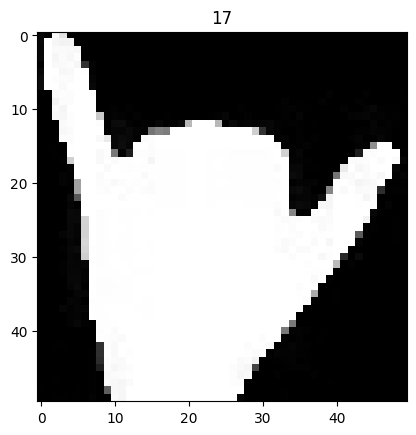

In [13]:
print('Images Shape', image_batch.shape)
print('Labels Shape', labels_batch.shape)
# pick random example in the first batch
random_batch_idx = np.random.choice(len(image_batch)) # batch)size = 16, normalized_train_dataset = 24000/16 = 1500
plt.imshow(image_batch[random_batch_idx],cmap='gray')
plt.title(class_names[labels_batch[random_batch_idx]])

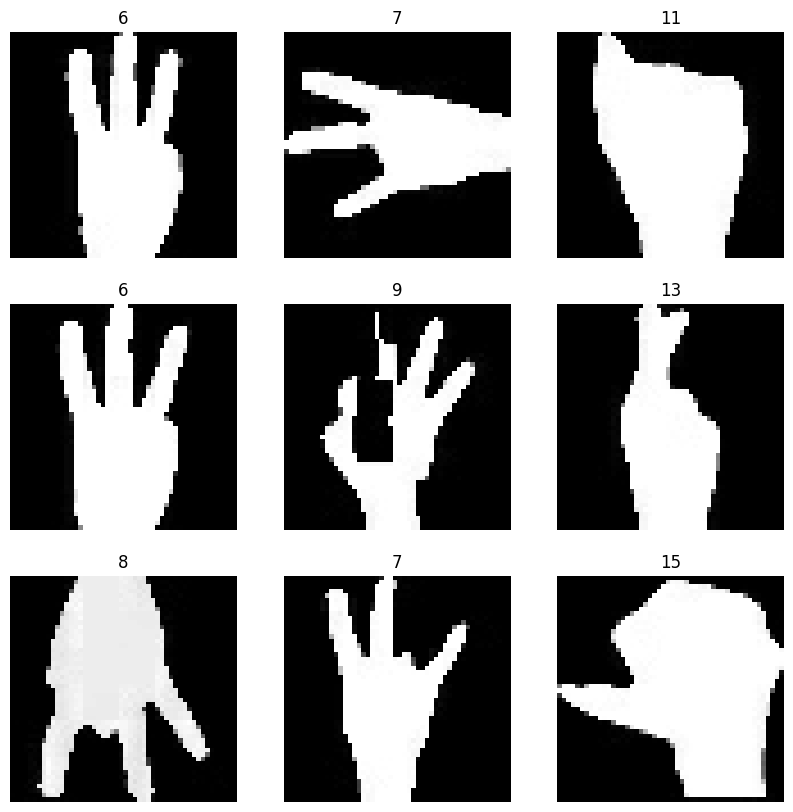

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i],cmap='gray')
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

# Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = normalized_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
valid_dataset = normalized_valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = normalized_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Comparing Between Deep Learning Models

In [17]:
input_shape = (50, 50, 1)
num_classes = 20

In [18]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## VGG16 Model

[`VGG16 Architecture`](https://arxiv.org/pdf/1409.1556.pdf)

In [19]:
# Build the vgg16 model
vgg16_model = Sequential()

# Block 1
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape)) # layer 1 output_shape=50x50,64
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # layer 2 output_shape=50x50,64
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2))) # output_shape=25x25,64

# Block 2
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # layer 3 output_shape=25x25,128
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # layer 4 output_shape=25x25,128
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2))) # output_shape=12x12,128

# Block 3
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same')) # layer 5 output_shape=12x12,256
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same')) # layer 6 output_shape=12x12,256
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same')) # layer 7 output_shape=12x12,256
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2))) # output_shape=6x6,256

# Block 4
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 8 output_shape=6x6,512
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 9 output_shape=6x6,512
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 10 output_shape=6x6,512
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2))) # output_shape=3x3,512

# Block 5
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 11 output_shape=3x3,512
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 12 output_shape=3x3,512
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same')) # layer 13 output_shape=3x3,512
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2))) # output_shape=1x1,512

vgg16_model.add(Flatten()) # output_shape=512

# Dense layers
vgg16_model.add(Dense(4096, activation='relu')) # layer 14 output_shape=4096
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(4096, activation='relu')) # layer 15 output_shape=4096
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(num_classes, activation='softmax')) # layer 16 output_shape=20

# Build the model
vgg16_model.build()
# Compile the model
vgg16_model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(0.0001))
# Get the summary
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

### Train

In [20]:
now =time.time()
vgg16_epochs=20
# Fitting the model
vgg16_hist = vgg16_model.fit(train_dataset, validation_data=valid_dataset, epochs=vgg16_epochs, batch_size=batch_size, callbacks=[tensorboard_callback])

# To get total time of the training
later=time.time()
vgg16_training_time= later-now
print('Total Time is ', vgg16_training_time, 'seconds.')

Epoch 1/20
1500/1500 [==============================] - 66s 41ms/step - loss: 1.1924 - accuracy: 0.5983 - val_loss: 0.2941 - val_accuracy: 0.9041
Epoch 2/20
1500/1500 [==============================] - 66s 44ms/step - loss: 0.1455 - accuracy: 0.9566 - val_loss: 0.1065 - val_accuracy: 0.9714
Epoch 3/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0700 - accuracy: 0.9815 - val_loss: 0.0558 - val_accuracy: 0.9845
Epoch 4/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0428 - accuracy: 0.9887 - val_loss: 0.0255 - val_accuracy: 0.9930
Epoch 5/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0296 - accuracy: 0.9930 - val_loss: 0.0307 - val_accuracy: 0.9937
Epoch 6/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0365 - accuracy: 0.9905 - val_loss: 0.0549 - val_accuracy: 0.9872
Epoch 7/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.0210 -

### Plot Performance

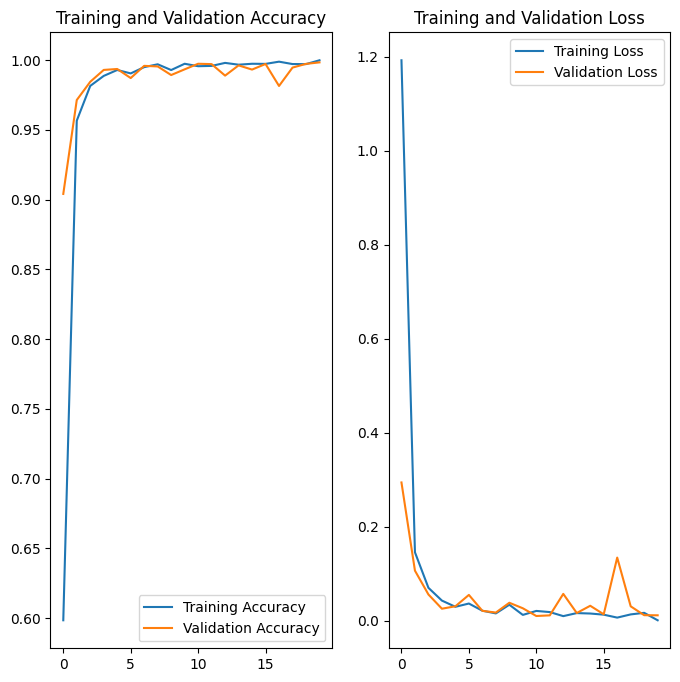

In [21]:
acc = vgg16_hist.history['accuracy']
val_acc = vgg16_hist.history['val_accuracy']

loss = vgg16_hist.history['loss']
val_loss = vgg16_hist.history['val_loss']

epochs_range = range(vgg16_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate

In [22]:
print('\nEvaluating:')
(vgg16_test_loss, vgg16_test_accuracy) = vgg16_model.evaluate(test_dataset)
print(f'\nTest accuracy: {vgg16_test_accuracy * 100:>0.1f}%, Test loss: {vgg16_test_loss:>8f}')


Evaluating:
750/750 [==============================] - 16s 21ms/step - loss: 0.0260 - accuracy: 0.9958

Test accuracy: 99.6%, Test loss: 0.025997


### Save the Model

In [24]:
vgg16_model.save('outputs/vgg16_model')
vgg16_model.save(os.path.join('outputs/vgg16_model/saved_model','vgg16_model.h5'))

INFO:tensorflow:Assets written to: outputs/vgg16_model\assets


INFO:tensorflow:Assets written to: outputs/vgg16_model\assets


### Load the Model

In [25]:
vgg16__model = load_model('outputs/vgg16_model/saved_model/vgg16_model.h5')

## Lenet-5 Model

In [26]:
lenet_model = Sequential()

# Layer 1 - Convolutional layer with 6 filters of size 5x5, stride of 1
lenet_model.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape))

# Layer 2 - Average pooling layer with size 2x2 and stride of 2
lenet_model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3 - Convolutional layer with 16 filters of size 5x5, stride of 1
lenet_model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu'))

# Layer 4 - Average pooling layer with size 2x2 and stride of 2
lenet_model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 5 - Flatten layer to flatten the output of the previous layer
lenet_model.add(Flatten())

# Layer 6 - Fully connected layer with 120 units
lenet_model.add(Dense(units=120, activation='relu'))

# Layer 7 - Fully connected layer with 84 units
lenet_model.add(Dense(units=84, activation='relu'))

# Layer 8 - Output layer with 20 units for 20 classes
lenet_model.add(Dense(units=num_classes, activation='softmax'))

# Build the model
lenet_model.build()
# Compile the model
lenet_model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'], optimizer=Adam(0.0001))

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 23, 23, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_14 (Conv2D)          (None, 19, 19, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 9, 9, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 1296)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

### Train

In [ ]:
now =time.time()
lenet_epochs=20
# Fitting the model
lenet_hist = lenet_model.fit(train_dataset, validation_data=valid_dataset, epochs=lenet_epochs, batch_size=batch_size, callbacks=[tensorboard_callback])

# To get total time of the training
later=time.time()
lenet_training_time= later-now
print('Total Time is ', lenet_training_time, 'seconds.')

Epoch 1/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.8692 - accuracy: 0.7768 - val_loss: 0.2833 - val_accuracy: 0.9242
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2002 - accuracy: 0.9463 - val_loss: 0.1519 - val_accuracy: 0.9588
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1187 - accuracy: 0.9684 - val_loss: 0.1273 - val_accuracy: 0.9638
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0814 - accuracy: 0.9779 - val_loss: 0.1045 - val_accuracy: 0.9708
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0586 - accuracy: 0.9845 - val_loss: 0.0934 - val_accuracy: 0.9736
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0427 - accuracy: 0.9891 - val_loss: 0.0925 - val_accuracy: 0.9747
Epoch 7/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0310 - accuracy: 0.9921 - val_loss: 0.0875 - val_accuracy

### Plot Performance

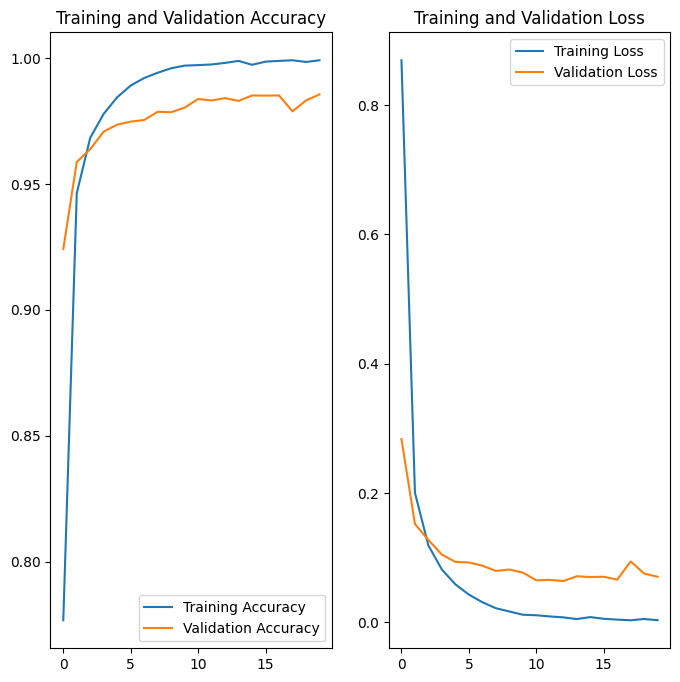

In [ ]:
acc = lenet_hist.history['accuracy']
val_acc = lenet_hist.history['val_accuracy']

loss = lenet_hist.history['loss']
val_loss = lenet_hist.history['val_loss']

epochs_range = range(lenet_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate

In [ ]:
print('\nEvaluating:')
(lenet_test_loss, lenet_test_accuracy) = lenet_model.evaluate(test_dataset)
print(f'\nTest accuracy: {lenet_test_accuracy * 100:>0.1f}%, Test loss: {lenet_test_loss:>8f}')


Evaluating:
750/750 [==============================] - 2s 2ms/step - loss: 0.1050 - accuracy: 0.9781

Test accuracy: 97.8%, Test loss: 0.105029


### Save the Model

In [ ]:
lenet_model.save('outputs/lenet_model')
lenet_model.save(os.path.join('outputs/lenet_model/saved_model','lenet_model.h5'))

INFO:tensorflow:Assets written to: outputs/lenet_model\assets


INFO:tensorflow:Assets written to: outputs/lenet_model\assets


### Load the Model

In [ ]:
lenet__model = load_model('outputs/lenet_model/saved_model/lenet_model.h5')

## GoogleNet

In [37]:
# Define the inception module, which is used in several blocks of the model
def inception_module(x, filters):
    # 1x1 convolution
    path1 = Conv2D(filters[0], (1,1), padding='same', activation='relu')(x)
    # 3x3 convolution
    path2 = Conv2D(filters[1], (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters[2], (3,3), padding='same', activation='relu')(path2)
    # 5x5 convolution
    path3 = Conv2D(filters[3], (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters[4], (5,5), padding='same', activation='relu')(path3)
    # max pooling
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(filters[5], (1,1), padding='same', activation='relu')(path4)
    # concatenate filters
    output = Concatenate()([path1, path2, path3, path4])
    return output

# Define the inputs to the model
inputs = Input(shape=input_shape)

# Block 1
x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(inputs)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

# Block 2
x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

# Block 3
x = inception_module(x, [64,96,128,16,32,32])
x = inception_module(x, [128,128,192,32,96,64])
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

# Block 4
x = inception_module(x, [192,96,208,16,48,64])
x = inception_module(x, [160,112,224,24,64,64])
x = inception_module(x, [128,128,256,24,64,64])
x = inception_module(x, [112,144,288,32,64,64])
x = inception_module(x, [256,160,320,32,128,128])
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

# Block 5
x = inception_module(x, [256,160,320,32,128,128])
x = inception_module(x, [384,192,384,48,128,128])

# Add a global average pooling layer to reduce the number of parameters
x = AveragePooling2D((7,7),padding='same')(x)

# Flatten the output
x = Flatten()(x)

# Add a fully connected layer with 1024 units
x = Dense(1024, activation='relu')(x)

# Add a dropout layer to reduce overfitting
x = Dropout(0.5)(x)

# Define the output layer with softmax activation for 1000 classes
outputs = Dense(20, activation='softmax')(x)

# Create the model
googleNet_model = Model(inputs, outputs)

# Compile the model
googleNet_model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'], optimizer=Adam(0.0001))

googleNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_151 (Conv2D)            (None, 25, 25, 64)   3200        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 13, 13, 64)  0           ['conv2d_151[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 13, 13, 64)   4160        ['max_pooling2d_38[0][0]'] 

### Train

In [38]:
now =time.time()
googleNet_epochs=20
# Fitting the model
googleNet_hist = googleNet_model.fit(train_dataset, validation_data=valid_dataset, epochs=googleNet_epochs, batch_size=batch_size, callbacks=[tensorboard_callback])

# To get total time of the training
later=time.time()
googleNet_training_time= later-now
print('Total Time is ', googleNet_training_time, 'seconds.')

Epoch 1/20
1500/1500 [==============================] - 49s 29ms/step - loss: 1.4758 - accuracy: 0.4717 - val_loss: 0.3700 - val_accuracy: 0.8747
Epoch 2/20
1500/1500 [==============================] - 43s 29ms/step - loss: 0.2960 - accuracy: 0.9043 - val_loss: 0.6156 - val_accuracy: 0.7853
Epoch 3/20
1500/1500 [==============================] - 44s 29ms/step - loss: 0.1613 - accuracy: 0.9503 - val_loss: 0.0948 - val_accuracy: 0.9720
Epoch 4/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0997 - accuracy: 0.9694 - val_loss: 0.0834 - val_accuracy: 0.9762
Epoch 5/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0734 - accuracy: 0.9780 - val_loss: 0.0507 - val_accuracy: 0.9853
Epoch 6/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0666 - accuracy: 0.9818 - val_loss: 0.0431 - val_accuracy: 0.9868
Epoch 7/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0450 - accuracy: 0.9872 - val_loss: 0.2288 -

### Plot Performance

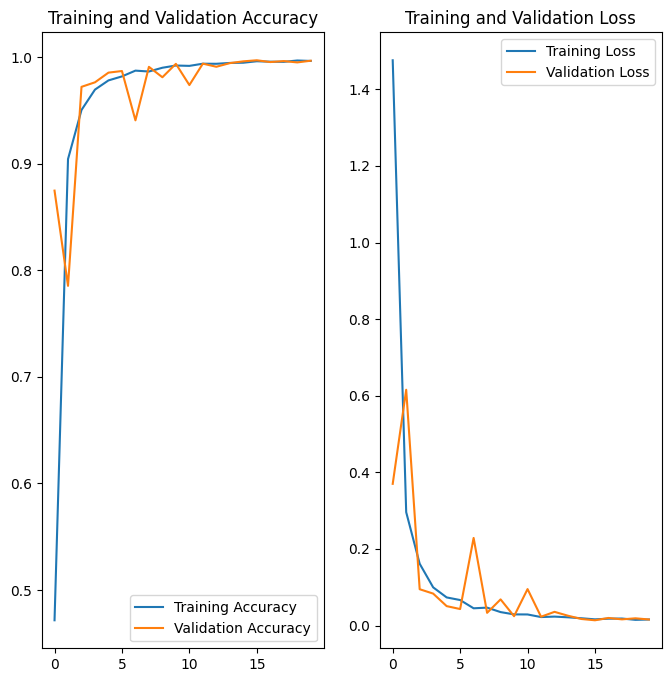

In [39]:
acc = googleNet_hist.history['accuracy']
val_acc = googleNet_hist.history['val_accuracy']

loss = googleNet_hist.history['loss']
val_loss = googleNet_hist.history['val_loss']

epochs_range = range(googleNet_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate

In [40]:
print('\nEvaluating:')
(googleNet_test_loss, googleNet_test_accuracy) = googleNet_model.evaluate(test_dataset)
print(f'\nTest accuracy: {googleNet_test_accuracy * 100:>0.1f}%, Test loss: {googleNet_test_loss:>8f}')


Evaluating:
750/750 [==============================] - 9s 12ms/step - loss: 0.0216 - accuracy: 0.9951

Test accuracy: 99.5%, Test loss: 0.021587


### Save the Model

In [41]:
googleNet_model.save('outputs/googleNet_model')
googleNet_model.save(os.path.join('outputs/googleNet_model/saved_model','googleNet_model.h5'))

INFO:tensorflow:Assets written to: outputs/googleNet_model\assets


INFO:tensorflow:Assets written to: outputs/googleNet_model\assets


### Load the Model

In [42]:
googleNet__model = load_model('outputs/googleNet_model/saved_model/googleNet_model.h5')

# Plotting the Compare Results

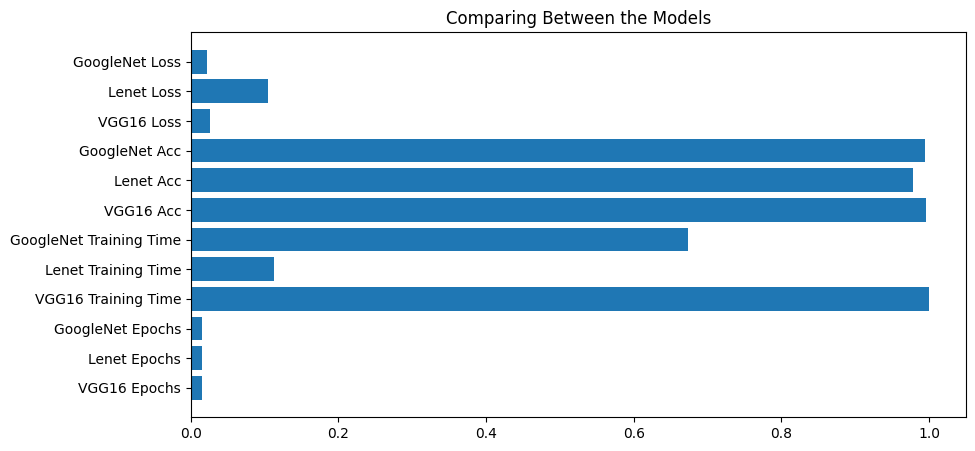

In [56]:
data=[]
data=[vgg16_epochs,lenet_epochs,googleNet_epochs,
     vgg16_training_time,lenet_training_time,googleNet_training_time,
     vgg16_test_accuracy,lenet_test_accuracy,googleNet_test_accuracy,
     vgg16_test_loss,lenet_test_loss,googleNet_test_loss]
min=np.min(data)
max=np.max(data)

def NormalizeData(value):
    
    return (value - min) / (max - min)

x = ["VGG16 Epochs", "Lenet Epochs", "GoogleNet Epochs",
     "VGG16 Training Time", "Lenet Training Time", "GoogleNet Training Time",
     "VGG16 Acc",  "Lenet Acc", "GoogleNet Acc",
     "VGG16 Loss", "Lenet Loss","GoogleNet Loss"]
y = [NormalizeData(vgg16_epochs), NormalizeData(lenet_epochs),NormalizeData(googleNet_epochs),
     NormalizeData(vgg16_training_time), NormalizeData(lenet_training_time),NormalizeData(googleNet_training_time),
     (vgg16_test_accuracy), (lenet_test_accuracy),(googleNet_test_accuracy),
     (vgg16_test_loss), (lenet_test_loss),(googleNet_test_loss)]

# setting figure size by using figure() function
plt.figure(figsize = (10,5))
     
# making the bar chart on the data
plt.barh(x, y)

# giving title to the plot
plt.title("Comparing Between the Models")
       
# visualizing the plot
plt.show()

With same number of epochs for each model. It is obvious that googleNet and vgg16 has the best accuracy but googleNet has the lowest loss. The Lenet-5 has the fastest training time but has the larger loss and less accuracy. So, the best model to pick in this case is googleNet.

# Test

In [58]:
# Retrieve a batch of images from the test set
test_image_batch, test_label_batch = next(iter(test_dataset))

In [59]:
predictions = googleNet__model.predict(test_image_batch)
print('Predictions:\n', predictions)
print('Labels:\n', test_label_batch)

1/1 [==============================] - 1s 555ms/step
Predictions:
 [[3.57902770e-11 5.49814601e-29 9.45404112e-27 1.49015243e-18
  1.78304163e-07 9.99999881e-01 1.63575612e-19 3.18303597e-14
  1.07782542e-11 1.57930377e-10 1.22632085e-28 5.17391082e-19
  2.70263755e-15 1.75701229e-28 9.49330980e-15 2.72555394e-12
  2.82610554e-20 7.97701020e-17 3.00849556e-23 4.18994041e-21]
 [1.56842026e-31 3.98348493e-10 1.72455564e-19 1.07637357e-10
  1.35566901e-29 1.92867863e-27 5.43477138e-23 6.69123179e-24
  4.32352120e-21 2.97290121e-23 1.00000000e+00 1.40810236e-23
  7.58625030e-21 1.37400904e-17 2.83275810e-25 3.31745244e-20
  7.63882887e-24 1.60729090e-19 4.90197550e-14 7.03476929e-11]
 [4.58115795e-10 7.24181671e-17 7.52926098e-18 4.43051939e-16
  1.22276856e-16 1.69298950e-16 1.89550960e-15 2.08230133e-16
  1.32903725e-13 2.28907945e-18 6.73838744e-16 9.99999523e-01
  7.35233153e-15 6.97627982e-15 4.96026075e-07 6.23392830e-12
  3.66196207e-09 3.61783581e-09 1.03708153e-08 9.89223078e-11]


Text(0.5, 1.0, 'Predicted: 4, True: 4')

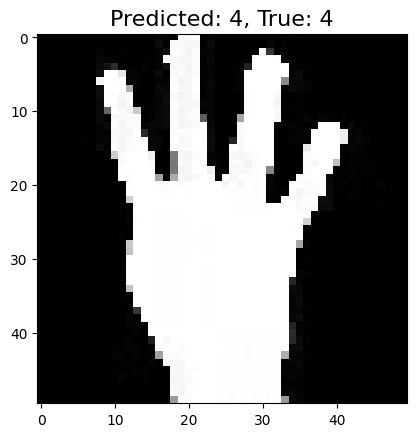

In [60]:
# pick random example in the first batch
random_batch_idx = np.random.choice(len(image_batch))
plt.imshow(test_image_batch[random_batch_idx], cmap='gray')
pred = np.argmax(predictions, axis=1)
plt.title("Predicted: {}, True: {}".format(pred[random_batch_idx], test_label_batch[random_batch_idx]), fontsize=16)

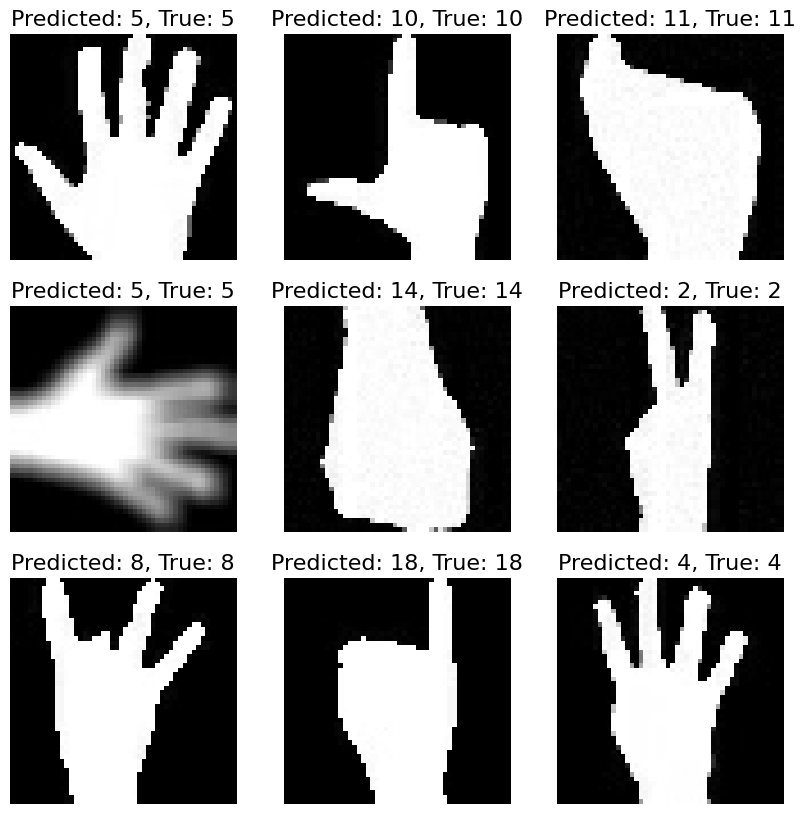

In [61]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_image_batch[i], cmap='gray')
    plt.title("Predicted: {}, True: {}".format(pred[i], test_label_batch[i].numpy()), fontsize=16)
    plt.axis("off")

# Confusion Matrix

In [62]:
# Obtain the predicted and true labels
predicted_labels = []
true_labels = []
for images, labels in test_dataset:
    batch_predicted_labels = googleNet__model.predict(images)
    batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)
    predicted_labels.extend(batch_predicted_labels)
    true_labels.extend(labels.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'Confusion Matrix')

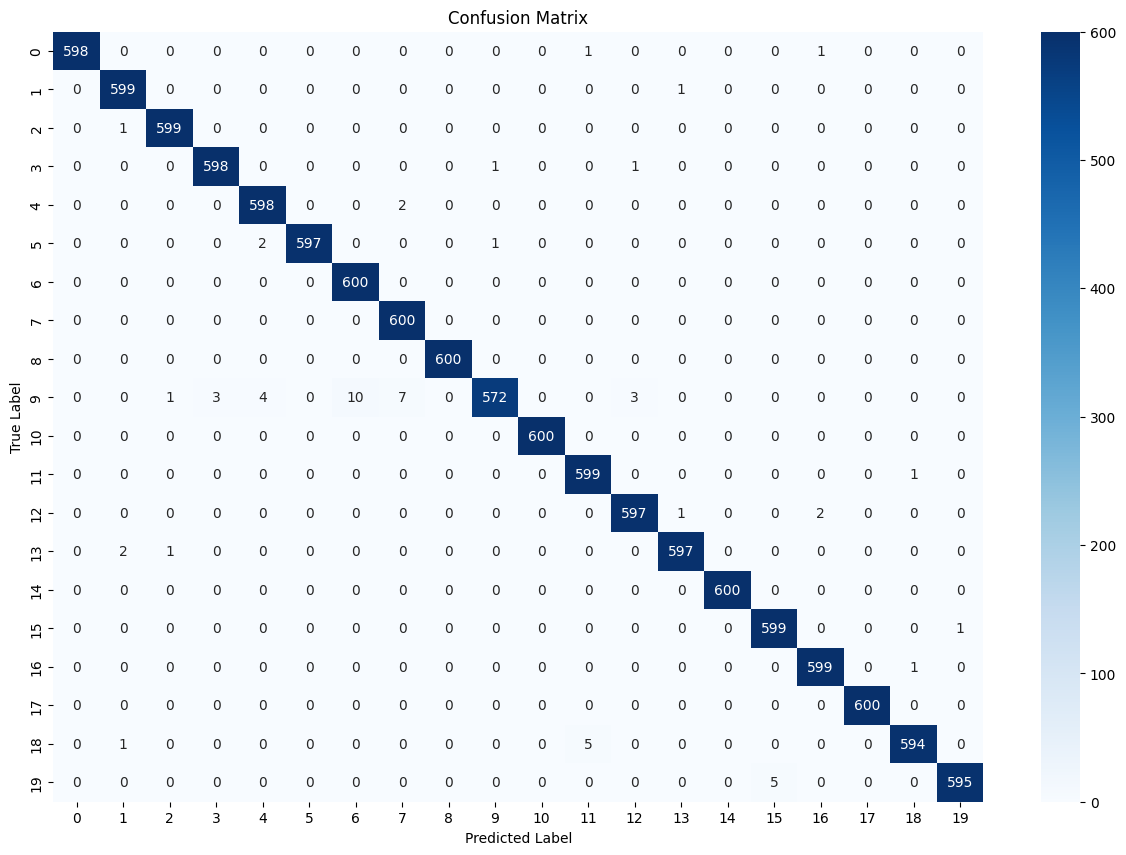

In [63]:
# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Testing on live captured image

In [64]:
# # return keys pressed
# import cv2 as cv
# img = cv.imread('test/opencv_frame_0.png') # load a dummy image
# while(1):
#     cv.imshow('img',img)
#     k = cv.waitKey(33)
#     if k%256==27:    # Esc key to stop
#         break
#     if not k%256==-1:  # normally -1 returned,so don't print it
#         print (k) # else print its value

In [73]:
cam = cv.VideoCapture(0)

cv.namedWindow("frame")

img_counter = 0

while True:
    ret, frame = cam.read()
    frame=cv.flip(frame,1)
    kernel = np.ones((3,3),np.uint8)
    
    # define region of interest
    roi=frame[100:350, 100:350]
    cv.rectangle(frame,(100,100),(350,350),(0,255,0),0)    
    
    # convert region of interest into hsv color
    hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    # define range of skin color in HSV
    lower_skin = np.array([0,20,70], dtype=np.uint8)
    upper_skin = np.array([20,255,255], dtype=np.uint8)
        
    # extract skin colur image
    mask = cv.inRange(hsv, lower_skin, upper_skin)
    
    # extrapolate the hand to fill dark spots within
    mask = cv.dilate(mask,kernel,iterations = 3)
        
    # blur the image
    mask = cv.GaussianBlur(mask,(3,3),10) 
    
    test_mask=mask
    test_mask = cv.resize(test_mask, (50, 50))
    test_mask = tf.keras.utils.img_to_array(test_mask)
    test_mask = test_mask/255.
    test_mask = np.array([test_mask])
    test_mask_prediction = googleNet__model.predict(test_mask)
    test_mask_prediction_max=np.max(test_mask_prediction, axis=1)
 
    # print prediction on frame
    font = cv.FONT_HERSHEY_SIMPLEX
    if test_mask_prediction_max[0]<0.95:
        cv.putText(frame,'Put hand correctly in the box',(100,50), font, 1, (0,0,255), 3, cv.LINE_AA)
    else:
        test_mask_prediction_label = np.argmax(test_mask_prediction, axis=1)
        mask_label = np.array2string(test_mask_prediction_label[0])
        cv.putText(frame,mask_label,(100,50), font, 1, (0,0,255), 3, cv.LINE_AA)
    
    if not ret:
        print("failed to grab frame")
        break
        
    cv.imshow("frame", frame)
    cv.imshow('mask', mask)

    k = cv.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
        
    # elif k%256 == 112:
    #     test_mask=mask
    #     test_mask = cv.resize(test_mask, (50, 50))
    #     test_mask = tf.keras.utils.img_to_array(test_mask)
    #     test_mask = test_mask/255.
    #     test_mask = np.array([test_mask])
    #     test_mask_prediction = vgg16__model.predict(test_mask)
    #     test_mask_prediction_=np.max(test_mask_prediction, axis=1)
    #     if test_mask_prediction_ > 0.9:
    #         test_mask_prediction_label = np.argmax(test_mask_prediction, axis=1)
    #         mask_label = test_mask_prediction_label
    #         mask_label = np.array2string(mask_label)
    #         print(type(mask_label))
    #     else:
    #         print('nothing')
        
    elif k%256 == 32:
        # SPACE pressed
        img_name = "test/opencv_frame_{}.png".format(img_counter)
        cv.imwrite(img_name, mask)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
Escape hit, closing...


## Test Images

Loading the image using [`tf.keras.utils.load_img`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

1/1 [==============================] - 0s 27ms/step
Prediction:  [[5.0471681e-06 6.4884117e-15 1.2675309e-13 1.9609903e-09 1.4224869e-03
  9.9854738e-01 9.4719721e-10 2.9902586e-07 2.6107343e-06 1.8907787e-05
  1.4118277e-14 1.0799088e-09 3.8608626e-08 1.7141114e-14 3.4350506e-07
  2.8921847e-06 1.3827446e-10 4.5496051e-09 4.7513603e-12 9.1132560e-11]]
Label:  [5]
1/1 [==============================] - 0s 31ms/step
Prediction:  [[2.4545253e-18 3.3052266e-04 7.0240674e-10 3.8644330e-06 3.5882212e-17
  6.1934398e-16 1.8145254e-12 2.6205215e-13 3.0082974e-12 1.5513938e-13
  9.9966538e-01 6.3538543e-14 1.1728966e-11 5.8861964e-09 1.7394542e-14
  1.6572316e-12 2.8474152e-13 3.6757195e-12 9.4047920e-08 1.3472540e-07]]
Label:  [10]
1/1 [==============================] - 0s 27ms/step
Prediction:  [[2.3403436e-14 5.8664045e-05 9.9991155e-01 2.2889717e-05 4.2906937e-12
  2.4876989e-13 4.8951338e-06 1.6997245e-06 1.1282033e-10 5.9214283e-10
  3.7135731e-10 4.0068795e-12 2.5607518e-08 2.8158161e-0

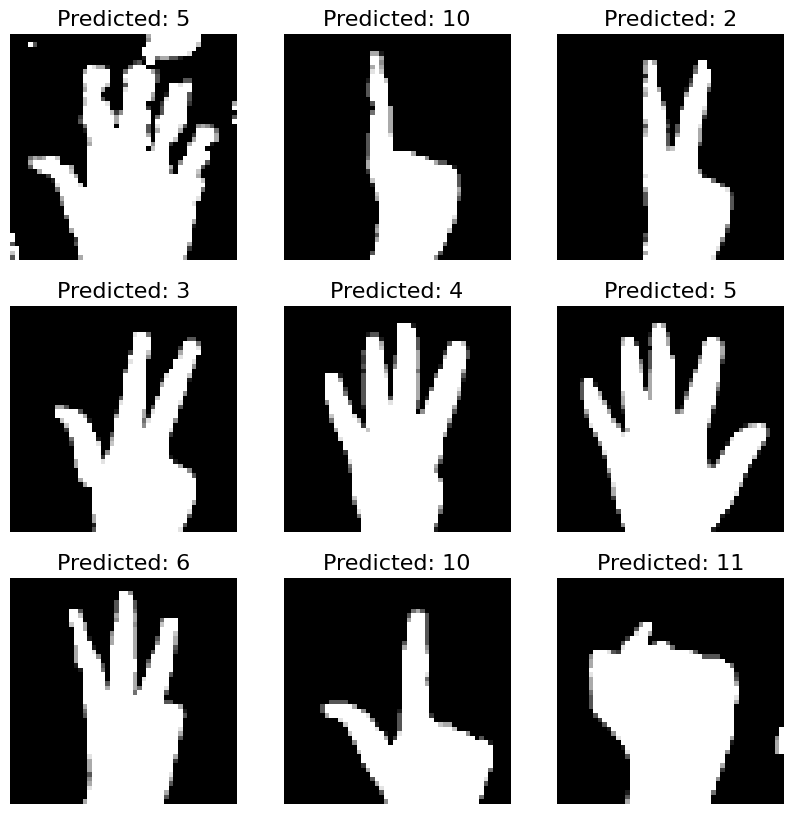

In [71]:
counter = 0
plt.figure(figsize=(10, 10))
for i in range(9):
    string_counter=str(counter)
    ax = plt.subplot(3, 3, i + 1)
    
    image_path='test/opencv_frame_'+string_counter+'.png'
    image = tf.keras.utils.load_img(image_path,
                                    color_mode='grayscale',
                                    target_size=(img_height, img_width))
    # Convert image to array
    test_array = tf.keras.utils.img_to_array(image)
    # Rescalling the image to be between 0 and 1
    test_array = test_array/255.
    #Convert single image to a batch.
    test_image = np.array([test_array])  # Add one dimension as model.predict expects (batch_size, img_height, img_width, channel)
    test_prediction = googleNet__model.predict(test_image)
    print('Prediction: ', test_prediction)
    test_prediction_label = np.argmax(test_prediction, axis=1)
    print('Label: ', test_prediction_label)
    plt.imshow(test_image[0], cmap='gray')
    plt.title("Predicted: {}".format(class_names[test_prediction_label[0]]), fontsize=16)
    counter+=1
    
    plt.axis("off")